In [60]:
# imports

import os
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from datetime import datetime

from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt



# Import data

In [ ]:

studies = [
    'data/MITHNEOS/gbo.ast.mithneos.spectra_2000-2021_V1_0/data/binzel2019',
    'data/MITHNEOS/gbo.ast.mithneos.spectra_2000-2021_V1_0/data/marsset2022',
]

# Initialize dictionaries to store data
spectral_data = {}
metadata = {}
neo_data = {}

for study in studies:
    data_dir = f'./{study}/'
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    
    for csv_file in csv_files:
        # Extract the NEO ID from the filename
        filename = os.path.basename(csv_file)
        neo_id = filename.split('_')[0]  # Assuming filenames are like '433_20161028.csv'
        
        # Read the spectral data CSV file
        data = pd.read_csv(csv_file, header=None, names=['Wavelength', 'Reflectance', 'Error'])
        
        # Read the corresponding XML file
        xml_file = csv_file.replace('.csv', '.xml')
        if os.path.exists(xml_file):
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            # Extract metadata from XML
            namespace = {'ns': 'http://pds.nasa.gov/pds4/pds/v1'}
            identification_area = root.find('ns:Identification_Area', namespace)
            observation_area = root.find('ns:Observation_Area', namespace)
            file_area = root.find('ns:File_Area_Observational', namespace)
            
            # Get logical_identifier (unique ID)
            logical_id = identification_area.find('ns:logical_identifier', namespace).text
            
            # Get observation times
            time_coords = observation_area.find('ns:Time_Coordinates', namespace)
            start_time = time_coords.find('ns:start_date_time', namespace).text
            stop_time = time_coords.find('ns:stop_date_time', namespace).text
            
            # Get target name
            target_identification = observation_area.find('ns:Target_Identification', namespace)
            target_name = target_identification.find('ns:name', namespace).text
            
            # Additional metadata can be extracted as needed
            
            # Store metadata
            meta = {
                'NEO_ID': neo_id,
                'Logical_ID': logical_id,
                'Start_Time': start_time,
                'Stop_Time': stop_time,
                'Target_Name': target_name,
                'Study': study
            }
        else:
            # Handle cases where XML file is missing
            meta = {
                'NEO_ID': neo_id,
                'Logical_ID': None,
                'Start_Time': None,
                'Stop_Time': None,
                'Target_Name': None,
                'Study': study
            }
        
        # Add the study and filename to the data
        data['NEO_ID'] = neo_id
        data['Study'] = study
        data['Filename'] = filename
        
        # Merge data and metadata
        data['Start_Time'] = meta['Start_Time']
        data['Stop_Time'] = meta['Stop_Time']
        data['Target_Name'] = meta['Target_Name']
        
        # Append to the spectral data dictionary
        if neo_id in spectral_data:
            spectral_data[neo_id] = pd.concat([spectral_data[neo_id], data])
        else:
            spectral_data[neo_id] = data
        
        # Store metadata
        if neo_id in metadata:
            metadata[neo_id].append(meta)
        else:
            metadata[neo_id] = [meta]



### Read observation parameters

In [24]:

marsset_meta_file = './data/MITHNEOS/gbo.ast.mithneos.spectra_2000-2021_V1_0/data/observationalparameters_marsset.csv'
marsset_meta = pd.read_csv(marsset_meta_file, header=None, names=[
    'ASTEROID_NUMBER',
    'ASTEROID_DESIGNATION',
    'ASTEROID_NAME',
    'FILENAME',
    'START_TIME_OBS',
    'STOP_TIME_OBS',
    'EXPOSURE_COUNT',
    'TOTAL_INTEGRATION_TIME',
    'RIGHT_ASCENSION',
    'DECLINATION',
    'AIRMASS',
    'DISTANCE_GEOCENTRIC',
    'DISTANCE_HELIOCENTRIC',
    'APPARENT_V_MAG',
    'SOLAR_PHASE_ANGLE',
    'SOLAR_ANALOG_STAR'
])

binzel_meta_file = './data/MITHNEOS/gbo.ast.mithneos.spectra_2000-2021_V1_0/data/observationalparameters_marsset.csv'
binzel_meta = pd.read_csv(binzel_meta_file, header=None, names=[
    'ASTEROID_NUMBER',
    'ASTEROID_DESIGNATION',
    'ASTEROID_NAME',
    'FILENAME',
    'START_TIME_OBS',
    'STOP_TIME_OBS',
    'EXPOSURE_COUNT',
    'TOTAL_INTEGRATION_TIME',
    'RIGHT_ASCENSION',
    'DECLINATION',
    'AIRMASS',
    'DISTANCE_GEOCENTRIC',
    'DISTANCE_HELIOCENTRIC',
    'APPARENT_V_MAG',
    'SOLAR_PHASE_ANGLE',
    'SOLAR_ANALOG_STAR'
])

marsset_meta['SOURCE'] = 'marsset'
binzel_meta['SOURCE'] = 'binzel'

combined_meta = pd.concat([marsset_meta, binzel_meta], ignore_index=True)

### Merge data

In [25]:
for neo_id in spectral_data:
    data = spectral_data[neo_id]
    filenames = data['Filename'].unique()
    meta_df = combined_meta[combined_meta['FILENAME'].isin(filenames)]
    if not meta_df.empty:
        data = data.merge(meta_df, left_on='Filename', right_on='FILENAME', how='left')
        
    spectral_data[neo_id] = data

### Formatting

In [18]:
# timestamps

for neo_id in spectral_data:
    data = spectral_data[neo_id]
    data['Start_Time'] = pd.to_datetime(data['Start_Time'])
    data['Stop_Time'] = pd.to_datetime(data['Stop_Time'])
    # data['START_TIME_OBS'] = pd.to_datetime(data['START_TIME_OBS'])
    # data['STOP_TIME_OBS'] = pd.to_datetime(data['STOP_TIME_OBS'])

    spectral_data[neo_id] = data


# missing values

for neo_id in spectral_data:
    data = spectral_data[neo_id]
    data.replace(['-1', '-'], [pd.NA, pd.NA], inplace=True)
    data = data.apply(pd.to_numeric, errors='ignore')
    
    spectral_data[neo_id] = data

/var/folders/b6/5kj2tkgn6vx8kxcyhfg6pf9c0000gn/T/ipykernel_4398/570522320.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


### Make DataFrame

In [23]:
all_data = pd.concat(spectral_data.values(), ignore_index=True)

all_data.head()

,Wavelength,Reflectance,Error,NEO_ID,Study,Filename,Start_Time,Stop_Time,Target_Name
0,0.830,0.813,0.006,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8
1,0.835,0.804,0.005,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8
2,0.840,0.798,0.005,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8
3,0.845,0.791,0.005,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8
4,0.850,0.775,0.005,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8


# Preprocessing and feature extraction

### Normalization

In [ ]:
# at 1

def re_normalize_spectrum(data):
    data = data[data['Reflectance'] != -1].copy()
    data['Wavelength'] = data['Wavelength'].astype(float)
    data['Reflectance'] = data['Reflectance'].astype(float)
    norm_wavelength = 1.0  # microns
    if norm_wavelength in data['Wavelength'].values:
        norm_factor = data.loc[data['Wavelength'] == norm_wavelength, 'Reflectance'].values[0]
    else:
        norm_factor = np.interp(norm_wavelength, data['Wavelength'], data['Reflectance'])
    if norm_factor == 0:
        print(f"Normalization factor is zero at wavelength {norm_wavelength} microns for NEO {data['NEO_ID'].iloc[0]}.")
        return data
    data['Normalized_Reflectance'] = data['Reflectance'] / norm_factor
    return data


# alt approach of normalization over a range
def re_normalize_spectrum_range(data, norm_wavelength, delta=0.02):
    data = data[data['Reflectance'] != -1].copy()
    data['Wavelength'] = data['Wavelength'].astype(float)
    data['Reflectance'] = data['Reflectance'].astype(float)
    lower_bound = norm_wavelength - delta
    upper_bound = norm_wavelength + delta
    mask = (data['Wavelength'] >= lower_bound) & (data['Wavelength'] <= upper_bound)
    reflectance_values = data.loc[mask, 'Reflectance']
    if reflectance_values.empty:
        print(f"No data available in the normalization range for NEO {data['NEO_ID'].iloc[0]}")
        return data
    norm_factor = reflectance_values.mean()
    data['Normalized_Reflectance'] = data['Reflectance'] / norm_factor
    return data


for neo_id in spectral_data:
    data = spectral_data[neo_id]
    normalized_data = re_normalize_spectrum(data)
    # normalized_data = re_normalize_spectrum_range(data, norm_wavelength=1.0, delta=0.02)
    spectral_data[neo_id] = normalized_data



In [51]:
all_data = all_data.groupby(['Filename']).apply(re_normalize_spectrum).reset_index(drop=True)
print(all_data.columns)

Index(['Wavelength', 'Reflectance', 'Error', 'NEO_ID', 'Study', 'Filename',
       'Start_Time', 'Stop_Time', 'Target_Name', 'Normalized_Reflectance'],
      dtype='object')


/var/folders/b6/5kj2tkgn6vx8kxcyhfg6pf9c0000gn/T/ipykernel_4398/1526837363.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_data = all_data.groupby(['Filename']).apply(re_normalize_spectrum).reset_index(drop=True)


### Caliculate spectral slope

In [46]:
def calculate_spectral_slope(data, start_wavelength, end_wavelength):
    mask = (data['Wavelength'] >= start_wavelength) & (data['Wavelength'] <= end_wavelength)
    wavelength_range = data.loc[mask, 'Wavelength']
    reflectance_range = data.loc[mask, 'Normalized_Reflectance']
    
    if len(wavelength_range) < 2:
        return np.nan
    
    slope_coeffs = np.polyfit(wavelength_range, reflectance_range, 1)
    spectral_slope = slope_coeffs[0]
    return spectral_slope


# adjust for band-depth

def calculate_band_depth(data, band_range):
    mask = (data['Wavelength'] >= band_range[0]) & (data['Wavelength'] <= band_range[1])
    band_data = data.loc[mask]
    if band_data.empty:
        return np.nan
    wavelengths = band_data['Wavelength'].values
    reflectance = band_data['Normalized_Reflectance'].values
    left_edge = band_range[0]
    right_edge = band_range[1]
    left_reflectance = np.interp(left_edge, data['Wavelength'], data['Normalized_Reflectance'])
    right_reflectance = np.interp(right_edge, data['Wavelength'], data['Normalized_Reflectance'])
    continuum = interp1d([left_edge, right_edge], [left_reflectance, right_reflectance], kind='linear')
    continuum_reflectance = continuum(wavelengths)
    band_depth = 1 - (reflectance / continuum_reflectance)
    max_band_depth = np.max(band_depth)
    return max_band_depth

def calculate_band_center(data, band_range):
    mask = (data['Wavelength'] >= band_range[0]) & (data['Wavelength'] <= band_range[1])
    band_data = data.loc[mask]
    if band_data.empty:
        return np.nan
    wavelengths = band_data['Wavelength'].values
    reflectance = band_data['Normalized_Reflectance'].values
    left_edge = band_range[0]
    right_edge = band_range[1]
    left_reflectance = np.interp(left_edge, data['Wavelength'], data['Normalized_Reflectance'])
    right_reflectance = np.interp(right_edge, data['Wavelength'], data['Normalized_Reflectance'])
    continuum = interp1d([left_edge, right_edge], [left_reflectance, right_reflectance], kind='linear')
    continuum_reflectance = continuum(wavelengths)
    band_depth = 1 - (reflectance / continuum_reflectance)
    band_center_index = np.argmax(band_depth)
    band_center_wavelength = wavelengths[band_center_index]
    return band_center_wavelength

In [47]:
# get band info for band range (0.9-1.1 silicate materials)

def extract_features(group):
    wavelengths = group['Wavelength'].values
    reflectance = group['Normalized_Reflectance'].values
    
    data = group.copy()
    
    # Recalculate Spectral Slope
    spectral_slope = calculate_spectral_slope(data, start_wavelength=0.8, end_wavelength=1.5)
    
    # Calculate Band Depth at 1-micron Band (associated with silicates or olivene)
    band_depth_1um = calculate_band_depth(data, band_range=(0.9, 1.1))
    band_center_1um = calculate_band_center(data, band_range=(0.9, 1.1))

    #  Calculate Band Depth at 2-micron Band: ~1.8 to 2.2 microns (associated with pyroxene minerals or pyroxene)
    band_depth_2um = calculate_band_depth(data, band_range=(1.8, 2.2))
    band_center_2um = calculate_band_center(data, band_range=(1.8, 2.2))
    
    # Calculate Mean Reflectance (optional, may not be necessary after normalization)
    mean_reflectance = reflectance.mean()
    
    # Aggregate features
    features = {
        'NEO_ID': group['NEO_ID'].iloc[0],
        'Spectral_Slope': spectral_slope,
        'Band_Depth_1um': band_depth_1um,
        'Band_Center_1um': band_center_1um,
        'Band_Depth_2um': band_depth_2um,
        'Band_Center_2um': band_center_2um,
        'Mean_Reflectance': mean_reflectance
    }
    return pd.Series(features)



### Apply to data

Spectral Slope:

A positive slope indicates increasing reflectance with wavelength (reddening), which may suggest certain types of asteroid compositions.
A negative slope indicates decreasing reflectance with wavelength (bluing).

Band Depth:

Deeper bands (higher band depth values) suggest stronger absorption features, indicating the presence of specific minerals.
For example, a significant 1-micron band depth may indicate silicate-rich asteroids.

In [54]:
# Apply the updated feature extraction function
features_df = all_data.groupby(['Filename']).apply(extract_features).reset_index()

neo_features = features_df.groupby('Filename').agg({
    'Spectral_Slope': 'mean',
    'Band_Depth_1um': 'mean',
    'Band_Center_1um': 'mean',
    'Band_Depth_2um': 'mean',
    'Band_Center_2um': 'mean',
    'Mean_Reflectance': 'mean'
}).reset_index()

/var/folders/b6/5kj2tkgn6vx8kxcyhfg6pf9c0000gn/T/ipykernel_4398/2090991722.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = all_data.groupby(['Filename']).apply(extract_features).reset_index()


In [55]:

feature_columns = [
    'Spectral_Slope',
    'Band_Depth_1um',
    'Band_Center_1um',
    'Band_Depth_2um',
    'Band_Center_2um',
    'Mean_Reflectance'
]
X = neo_features[feature_columns].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

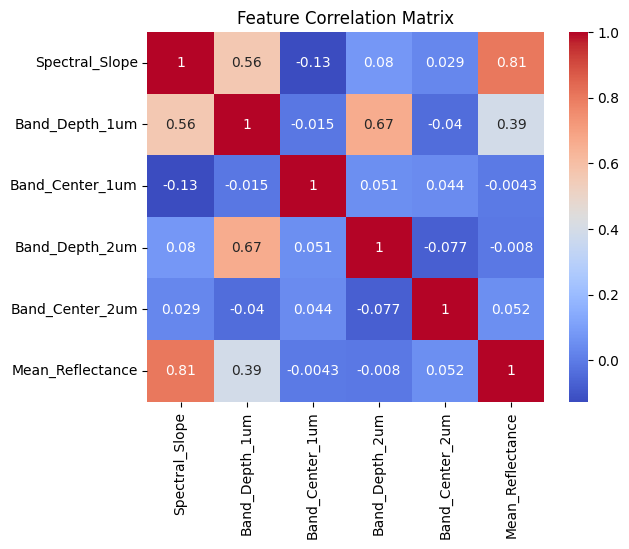

In [ ]:
# a little chart action

# Compute correlation matrix
corr_matrix = neo_features[feature_columns].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Anomaly detection

In [ ]:
# code code code for anomalies

### TODOs

Principal Component Analysis (PCA):
Reduce dimensionality and identify patterns in the spectral data.

Spectral Unmixing:
Use algorithms like Multiple Endmember Spectral Mixture Analysis (MESMA).

Spectral Libraries:
Match asteroid spectra to library spectra to infer composition.

Combine spectral analysis with other asteroid characteristics (e.g., density, orbit, albedo).